In [1]:
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.xception import preprocess_input, Xception
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numpy as np
import os

from sklearn.metrics import classification_report, confusion_matrix

## Declare some variables & functions

In [2]:
wd = os.path.sep.join([os.getcwd(), "data"])
train_path = os.path.sep.join([wd, "train"])
test_path = os.path.sep.join([wd, "test"])

models_arch_path =os.path.sep.join([wd, "models_architecture"])
models_history_path =os.path.sep.join([wd, "models_history"])
models_weights_path =os.path.sep.join([wd, "models_weight"])

In [17]:
def show_results(_model, _hist, metric):
    """
    Used to shows classification report, confusion matrix for the prediction of the test set and learning curves from the training
    :param _model: fitted model
    :param _hist: model's history
    :param metric: metric to show in the learning curves (accuracy/recall)
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.lineplot(x=range(len(_hist[metric])), y=_hist[metric], label=metric, ax=ax)
    sns.lineplot(x=range(len(_hist[metric])), y=_hist["val_"+metric], label="val "+metric, ax=ax)
    sns.lineplot(x=range(len(_hist[metric])), y=_hist["loss"], label="loss", ax=ax)
    sns.lineplot(x=range(len(_hist[metric])), y=_hist["val_loss"], label="val loss", ax=ax)

    y_true = X_test.classes
    y_pred = np.argmax(_model.predict(x=X_test, steps=test_step_per_epoch), axis=1)

    report = classification_report(y_true, y_pred)
    print(report)

    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)

def recall(y_true, y_pred):
    """
    Compute the recall metric
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def save(name):
    with open(os.path.sep.join([models_history_path, f"{name}.pickle"]), "wb") as handle:
        pickle.dump(hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(name):
    with open(os.path.sep.join([models_history_path, f"{name}.pickle"]), "rb") as handle:
        return pickle.load(handle)

## Declaration of the image generators used to train models without having to load images in cache
input from multiple directories with keras https://stackoverflow.com/questions/60787620/combine-two-data-generator-to-train-a-cnn

In [4]:
# generators
train_gen = ImageDataGenerator(validation_split=.15, rescale=1 / 255.0)
test_gen = ImageDataGenerator(rescale=1 / 255.0)

X_test = test_gen.flow_from_directory(test_path, target_size=(51,51), batch_size=32, shuffle=False)

# set the flow of generators for the train/test/validation
X_train = train_gen.flow_from_directory(train_path, target_size=(51,51), subset="training", batch_size=32, shuffle=True)
X_val = train_gen.flow_from_directory(train_path, target_size=(51,51), subset="validation", batch_size=32, shuffle=False)


# set the flow of generator for augmented data in train/validation
train_gen_augmented = ImageDataGenerator(rotation_range=25, horizontal_flip=True, vertical_flip=True, brightness_range=[.7, 1.3], zoom_range=.1, validation_split=.15, rescale=1 / 255.0)
X_train_aug = train_gen_augmented.flow_from_directory(train_path, target_size=(51,51), subset="training", batch_size=32, shuffle=True)
X_val_aug = train_gen_augmented.flow_from_directory(train_path, target_size=(51,51), subset="validation", batch_size=32, shuffle=False)

Found 83018 images belonging to 2 classes.
Found 165331 images belonging to 2 classes.
Found 29175 images belonging to 2 classes.
Found 165331 images belonging to 2 classes.
Found 29175 images belonging to 2 classes.


In [6]:
from math import ceil
epochs = 50
batch_size = 32
optimizer = Adam(learning_rate=0.000_1)

callback = lambda x: [EarlyStopping(monitor='val_recall', patience=2, mode="min"), ModelCheckpoint(filepath=os.path.sep.join([models_weights_path, f"{x}_weights.h5"]), monitor='val_recall', save_weights_only=True, save_best_only=True)]

train_step_per_epoch = int(ceil(len(X_train.classes)*.85 / batch_size))   # total number of images in the train set
validation_step_per_epoch = int(ceil(len(X_train.classes)*.15 / batch_size))   # total number of images in the train set
test_step_per_epoch = int(ceil(len(X_test.classes) / batch_size))

## CNN - Declaration of the model

In [6]:
def get_model():
    _model = Sequential()
    _model.add(SeparableConv2D(32, (3, 3), activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(MaxPooling2D((2, 2)))

    _model.add(SeparableConv2D(32, (3, 3), activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(MaxPooling2D((2, 2)))

    _model.add(SeparableConv2D(64, (3, 3), activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))

    _model.add(Flatten())

    _model.add(Dense(64, activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(Dropout(0.5))
    _model.add(Dense(2, activation="softmax"))
    return _model

model = get_model()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", recall])

In [ ]:
model.build((32, 51, 51, 3))
plot_model(model, to_file=os.path.sep.join([models_arch_path, "CNN.png"]), rankdir="LR")

## CNN - Model without data augmentation
### Perform classes weight to prioritize sample that are fewer (classe 1)

In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(X_train.classes), y=X_train.classes)
train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 0.698442001740497, 1: 1.7598139396261763}

In [8]:
hist = model.fit(x=X_train, validation_data=X_val, callbacks=callback("CNN_classic"), epochs=epochs, class_weight=train_class_weights, batch_size=batch_size, steps_per_epoch=train_step_per_epoch, validation_steps=validation_step_per_epoch).history

Epoch 1/50
4391/4391 [==============================] - 209s 47ms/step - loss: 0.5398 - accuracy: 0.7801 - recall: 0.7801 - val_loss: 0.5886 - val_accuracy: 0.7541 - val_recall: 0.7541
Epoch 2/50
4391/4391 [==============================] - 207s 47ms/step - loss: 0.4409 - accuracy: 0.8147 - recall: 0.8147 - val_loss: 0.4176 - val_accuracy: 0.8179 - val_recall: 0.8179
Epoch 3/50
4391/4391 [==============================] - 230s 52ms/step - loss: 0.4108 - accuracy: 0.8233 - recall: 0.8233 - val_loss: 0.4153 - val_accuracy: 0.8246 - val_recall: 0.8246


              precision    recall  f1-score   support

           0       0.89      0.87      0.88     59495
           1       0.70      0.73      0.71     23523

    accuracy                           0.83     83018
   macro avg       0.79      0.80      0.80     83018
weighted avg       0.84      0.83      0.83     83018



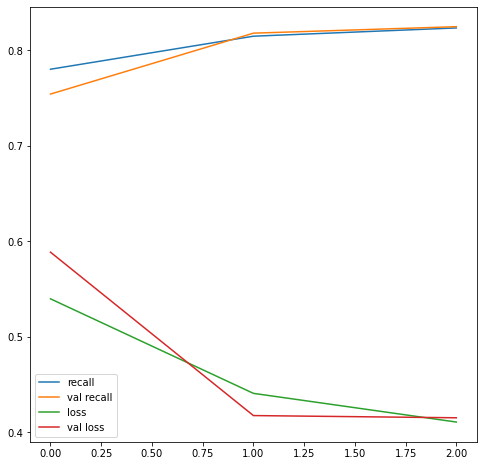

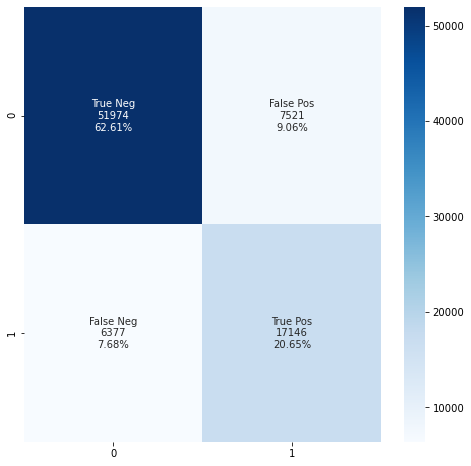

In [9]:
model.load_weights(os.path.sep.join([models_weights_path, "CNN_classic.h5"]))
save("history_classic")
hist = load("history_classic")
show_results(_model=model, _hist=hist, metric="recall")

## CNN - Model with data augmentation

In [10]:
# reset generators
X_train.reset()
X_val.reset()
X_test.reset()

In [8]:
model = get_model()
hist = model.fit(x=X_train_aug, validation_data=X_val_aug, callbacks=callback("CNN_DAugmentation"), epochs=epochs, class_weight=train_class_weights, batch_size=batch_size, steps_per_epoch=train_step_per_epoch, validation_steps=validation_step_per_epoch).history

Epoch 1/50
4391/4391 [==============================] - 359s 82ms/step - loss: 0.5257 - accuracy: 0.7744 - recall: 0.7744 - val_loss: 0.7414 - val_accuracy: 0.6399 - val_recall: 0.6399
Epoch 2/50
4391/4391 [==============================] - 326s 74ms/step - loss: 0.4496 - accuracy: 0.8082 - recall: 0.8082 - val_loss: 0.6655 - val_accuracy: 0.6758 - val_recall: 0.6758
Epoch 3/50
4391/4391 [==============================] - 346s 79ms/step - loss: 0.4274 - accuracy: 0.8149 - recall: 0.8149 - val_loss: 0.7641 - val_accuracy: 0.6017 - val_recall: 0.6017
Epoch 4/50
4391/4391 [==============================] - 341s 78ms/step - loss: 0.4166 - accuracy: 0.8207 - recall: 0.8207 - val_loss: 0.6521 - val_accuracy: 0.6827 - val_recall: 0.6827
Epoch 5/50
4391/4391 [==============================] - 344s 78ms/step - loss: 0.4098 - accuracy: 0.8234 - recall: 0.8234 - val_loss: 0.6681 - val_accuracy: 0.6864 - val_recall: 0.6864


              precision    recall  f1-score   support

           0       0.92      0.77      0.84     59495
           1       0.58      0.83      0.68     23523

    accuracy                           0.78     83018
   macro avg       0.75      0.80      0.76     83018
weighted avg       0.82      0.78      0.79     83018



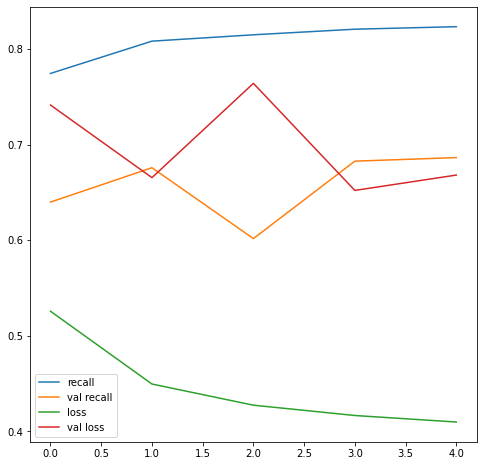

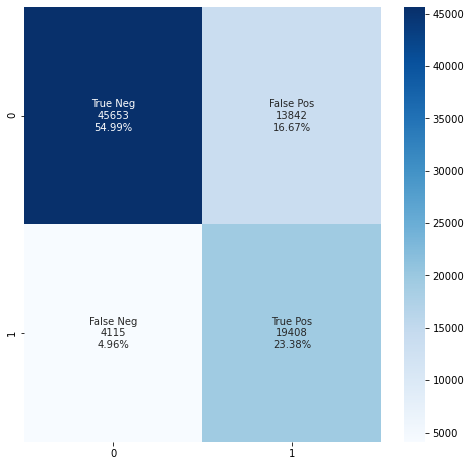

In [10]:
model.load_weights(os.path.sep.join([models_weights_path, "CNN_DAugmentation_weights.h5"]))
save("history_DAugmentation")
hist = load("history_DAugmentation")
show_results(_model=model, _hist=hist, metric="recall")

## CNN using a pre trained model to extract features + data augmentation

In [13]:
# news generators with appropriate params (preprocess function, target_size)
img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=.15)
X_train = img_datagen.flow_from_directory(train_path, target_size=(71,71), subset="training", batch_size=batch_size, shuffle=True)
X_val = img_datagen.flow_from_directory(train_path, target_size=(71,71), subset="validation", batch_size=batch_size, shuffle=False)
X_test = img_datagen.flow_from_directory(test_path, target_size=(71,71), batch_size=batch_size, shuffle=False)

Found 165331 images belonging to 2 classes.
Found 29175 images belonging to 2 classes.
Found 83018 images belonging to 2 classes.


In [14]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing

base_model = Xception(include_top=False, input_shape=(71, 71, 3))
base_model.trainable = False

flatten_layer = Flatten()
dense_layer = lambda x: Dense(x, activation='relu')
prediction_layer = Dense(2, activation='softmax')
dropout_layer = lambda x: Dropout(x)

model = Sequential([
    Resizing(71, 71),
    base_model,
    flatten_layer,
    dense_layer(16),
    dropout_layer(.25),
    dense_layer(32),
    dropout_layer(.5),
    prediction_layer
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", recall])

In [15]:
hist = model.fit(x=X_train, validation_data=X_val, callbacks=callback("Xception_TLearning"), epochs=epochs, class_weight=train_class_weights, batch_size=batch_size, steps_per_epoch=train_step_per_epoch, validation_steps=validation_step_per_epoch).history

Epoch 1/50
4392/4392 [==============================] - 1452s 330ms/step - loss: 0.5373 - accuracy: 0.7849 - recall: 0.7849 - val_loss: 0.6077 - val_accuracy: 0.7833 - val_recall: 0.7833
Epoch 2/50
4392/4392 [==============================] - 1421s 324ms/step - loss: 0.4861 - accuracy: 0.7924 - recall: 0.7924 - val_loss: 0.5959 - val_accuracy: 0.8002 - val_recall: 0.8002
Epoch 3/50
4392/4392 [==============================] - 1474s 336ms/step - loss: 0.4688 - accuracy: 0.7667 - recall: 0.7667 - val_loss: 0.5748 - val_accuracy: 0.6137 - val_recall: 0.6137
Epoch 4/50
4392/4392 [==============================] - 1472s 335ms/step - loss: 0.4543 - accuracy: 0.7627 - recall: 0.7627 - val_loss: 0.5045 - val_accuracy: 0.7195 - val_recall: 0.7195
Epoch 5/50
4392/4392 [==============================] - 1687s 384ms/step - loss: 0.4466 - accuracy: 0.7694 - recall: 0.7694 - val_loss: 0.6119 - val_accuracy: 0.6516 - val_recall: 0.6516


              precision    recall  f1-score   support

           0       0.94      0.72      0.81     59495
           1       0.55      0.87      0.68     23523

    accuracy                           0.76     83018
   macro avg       0.74      0.80      0.75     83018
weighted avg       0.83      0.76      0.78     83018



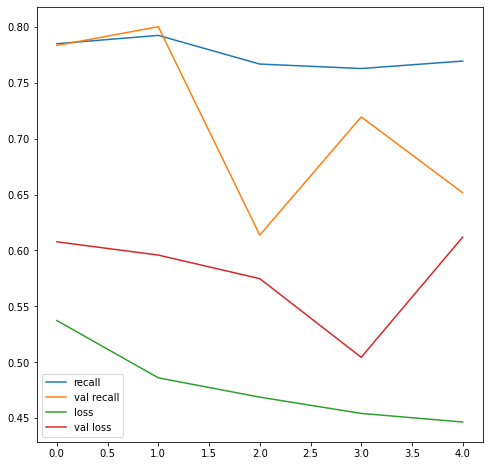

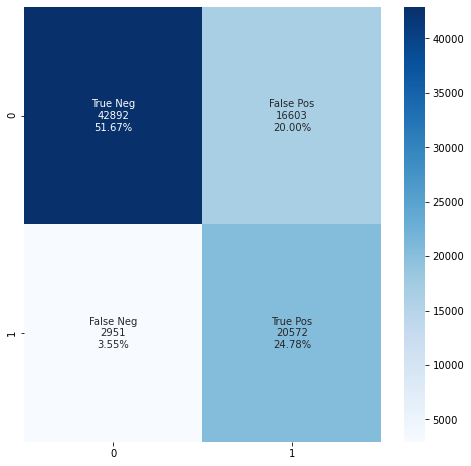

In [18]:
model.build(input_shape=(51, 51))
model.load_weights(os.path.sep.join([models_weights_path, "Xception_TLearning_weights.h5"]))
save("history_Xception_TLearning")
hist = load("history_Xception_TLearning")
show_results(_model=model, _hist=hist, metric="recall")